In [2]:
# Only run this when using kaggle
! sudo apt-get update

# Please install the following packages before running this notebook in google colab/kaggle
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra -y
! sudo apt install dvipng -y
! sudo apt install cm-super -y
! pip install pyopencl
! git clone https://github.com/williamjones7/RSCAM-Group-Project- temp;

Get:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5002 B]
Get:2 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]       
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:4 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:9 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [427 kB]
Get:10 https://packages.cloud.google.com/apt google-fast-socket/main amd64 Packages [448 B]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [975 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/restricted amd6

In [13]:
import sys
sys.path.insert(0, 'temp')

In [14]:
# Load packages
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyopencl as cl
import pyopencl.array as cl_array

import PyNetworkCPU

from matplotlib import rc
from PyNetwork import ActivationFunctions, ErrorFunctions, MetricFunctions

In [15]:
# Load context and queue
platform = cl.get_platforms()
devices = platform[0].get_devices()
context = cl.Context(devices)
queue = cl.CommandQueue(context)

gpu_activation = ActivationFunctions(context, queue)

In [16]:
# Set the text format same as in the report
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Roman'],'size':30})
rc('text', usetex=True)

In [17]:
def timing_activation_function(x, name):
    """
    Returns average time spent on corresponding activation function
    """

    # Set test data
    x_gpu = cl_array.to_device(queue, x)
    x_tensor = torch.tensor(x)
    x_tensor_gpu = x_tensor.cuda()

    # Load activation functions in PyNetwork
    activation_cpu = PyNetworkCPU.get_activation_function(name)
    activation_gpu = gpu_activation.get_activation_function(name)

    # Compute the running time for PyNetwork
    pynetwork_cpu_time = %timeit -o -q -r 10 -n 100 activation_cpu(x)
    pynetwork_gpu_time = %timeit -o -q -r 10 -n 100 activation_gpu(x_gpu)

    # Compute the running time for PyTorch
    if name == 'relu':
        torch_cpu_time = %timeit -o -q -r 10 -n 100 torch.nn.functional.relu(x_tensor)
        torch_gpu_time = %timeit -o -q -r 10 -n 100 torch.nn.functional.relu(x_tensor_gpu)
    elif name == 'softmax':
        torch_cpu_time = %timeit -o -q -r 10 -n 100 torch.nn.functional.softmax(x_tensor, dim=1)
        torch_gpu_time = %timeit -o -q -r 10 -n 100 torch.nn.functional.softmax(x_tensor_gpu, dim=1)
    
    return pynetwork_cpu_time.average, pynetwork_gpu_time.average, torch_cpu_time.average, torch_gpu_time.average

## Timing for ReLU

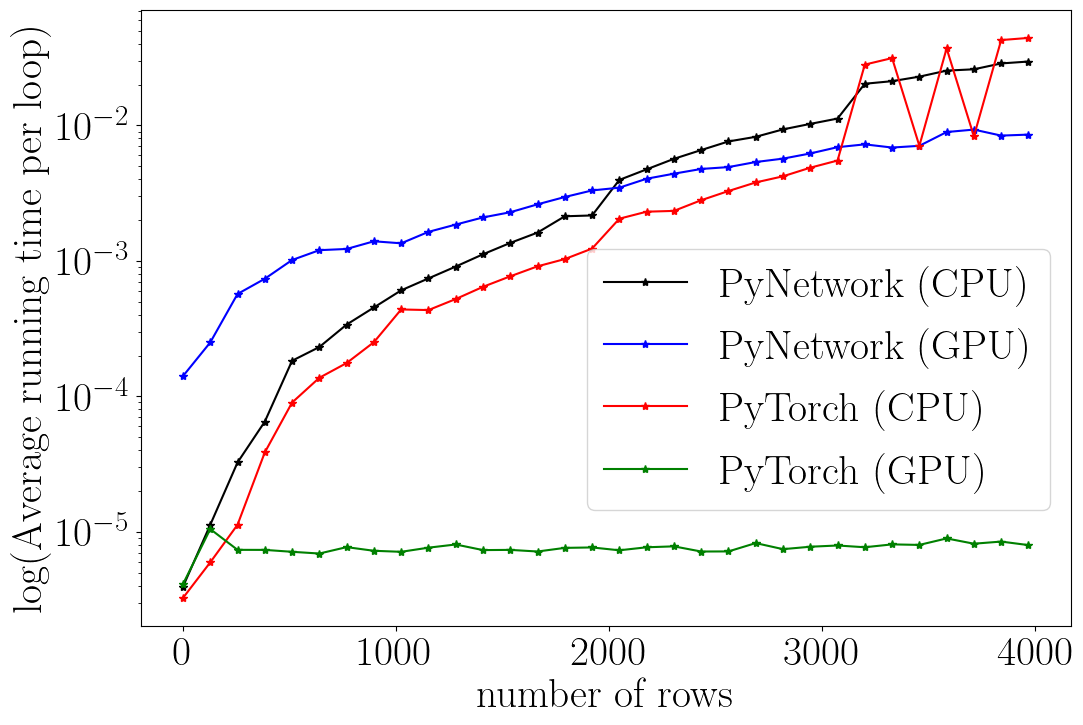

In [58]:
# # Test with different size (square matrix)

# Define x
n_rows = np.arange(0, 4096, 128)
timing_relu = np.zeros((len(n_rows), 4))

# Store the result
for i in range(len(n_rows)):
    x = np.random.rand(n_rows[i], n_rows[i]).astype(np.float32)
    timing_relu[i, :] = timing_activation_function(x, 'relu')

# Plot the result
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set(xlabel = 'number of rows', ylabel = 'log(Average running time per loop)')
ax.set_yscale('log')
ax.plot(n_rows, timing_relu[:, 0], 'k*-')
ax.plot(n_rows, timing_relu[:, 1], 'b*-')
ax.plot(n_rows, timing_relu[:, 2], 'r*-')
ax.plot(n_rows, timing_relu[:, 3], 'g*-')

plt.legend(['PyNetwork (CPU)', 'PyNetwork (GPU)', 'PyTorch (CPU)', 'PyTorch (GPU)'],
           loc='center right', bbox_to_anchor = (0,-0.1,1,1))

plt.savefig('relu_testing_with_square_matrix.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Test with different size (fixed number of columns, different number of rows)

# Define x
timing_relu_ = np.zeros((len(n_rows), 4))

# Store the result
for i in range(len(n_rows)):
    x = np.random.rand(n_rows[i], 4096).astype(np.float32)
    timing_relu_[i, :] = timing_activation_function(x, 'relu')

# Plot the result
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set(xlabel = 'number of rows', ylabel = 'log(Average running time per loop)')
ax.set_yscale('log')

ax.plot(n_rows, timing_relu_[:, 0], 'k*-')
ax.plot(n_rows, timing_relu_[:, 1], 'b*-')
ax.plot(n_rows, timing_relu_[:, 2], 'r*-')
ax.plot(n_rows, timing_relu_[:, 3], 'g*-')

plt.legend(['PyNetwork (CPU)', 'PyNetwork (GPU)', 'PyTorch (CPU)', 'PyTorch (GPU)'],
           loc='center right', bbox_to_anchor = (0,-0.1,1,1))

plt.savefig('relu_testing_with_regular_matrix.pdf', bbox_inches='tight')
plt.show()

## Timing the softmax

In [ ]:
# # Test with different size (square matrix)

# Define x
n_points = 6
n_rows = np.logspace(4, 3 + n_points, num = n_points, base = 2).astype(np.int32)
timing_softmax = np.zeros((n_points, 4))

# Store the result
for i in range(n_points):
    x = np.random.rand(n_rows[i], n_rows[i]).astype(np.float32)
    timing_softmax[i, :] = timing_activation_function(x, 'softmax')

# Plot the result
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

ax.axis([0, 2 ** (3 + n_points), 0, np.max(timing_softmax)])

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set(xlabel = 'number of rows', ylabel = 'Average running time per loop (s)')
ax.set_yscale('log')

ax.plot(n_rows, timing_softmax[:, 0], 'k*-')
ax.plot(n_rows, timing_softmax[:, 1], 'b*-')
ax.plot(n_rows, timing_softmax[:, 2], 'r*-')
ax.plot(n_rows, timing_softmax[:, 3], 'g*-')

plt.legend(['PyNetwork (CPU)', 'PyNetwork (GPU)', 'PyTorch (CPU)', 'PyTorch (GPU)'])
plt.savefig('softmax_testing_with_square_matrix.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# # Test with different size (fixed number of columns)

# Define x
timing_softmax_ = np.zeros((n_points, 4))

# Store the result
for i in range(n_points):
    x = np.random.rand(n_rows[i], 2 ** (3 + n_points))
    timing_softmax_[i, :] = timing_activation_function(x, 'softmax')

# Plot the result
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

ax.axis([0, 2 ** (3 + n_points), 0, np.max(timing_softmax_)])

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set(xlabel = 'number of rows', ylabel = 'Average running time per loop (s)')
ax.set_yscale('log')

ax.plot(n_rows, timing_softmax_[:, 0], 'k*-')
ax.plot(n_rows, timing_softmax_[:, 1], 'b*-')
ax.plot(n_rows, timing_softmax_[:, 2], 'r*-')
ax.plot(n_rows, timing_softmax_[:, 3], 'g*-')

plt.legend(['PyNetwork (CPU)', 'PyNetwork (GPU)', 'PyTorch (CPU)', 'PyTorch (GPU)'])
plt.savefig('softmax_testing_with_regular_matrix.pdf', bbox_inches='tight')
plt.show()